<a href="https://colab.research.google.com/github/vibhavjoshi123/Parkinson-Detection-using-Deep-Learning/blob/master/spiral_VGG_parkinson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import all dependencies

In [ ]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Define Few Parameters

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
healthy_path = 'spiral/training/healthy'
parkinson_path = 'spiral/training/parkinson'

# Use glob to grab images from path .jpg or jpeg
parkinson_files= glob(parkinson_path + '/*')
healthy_files = glob(healthy_path + '/*')

### Fetch Images and Class Labels from Files (This might take a while)

In [ ]:
# Preparing Labels
parkinson_labels = []
healthy_labels = []

parkinson_images=[]
healthy_images=[]

import cv2 

for i in range(len(parkinson_files)):
  image = cv2.imread(parkinson_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  parkinson_images.append(image)
  parkinson_labels.append('parkinson')
for i in range(len(healthy_files)):
  image = cv2.imread(healthy_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  healthy_images.append(image)
  healthy_labels.append('healthy')

### Visualize First 40 Images from Data set

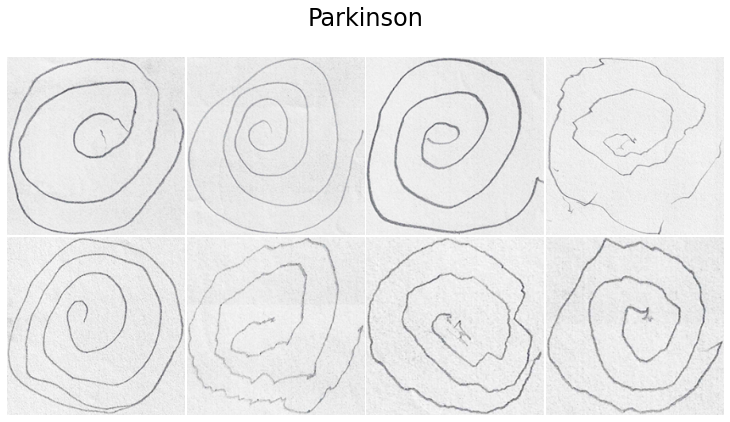

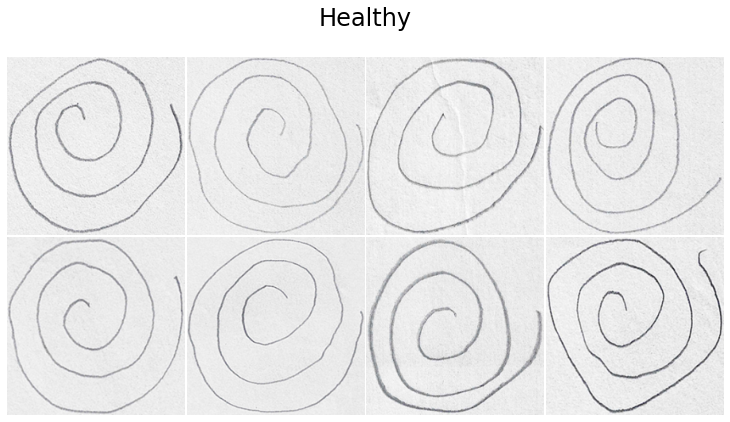

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 2, 4
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(parkinson_images, 'Parkinson')
plot_images(healthy_images, 'Healthy')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [ ]:
# Convert to array and Normalize to interval of [0,1]
parkinson_images = np.array(parkinson_images) / 255
healthy_images = np.array(healthy_images) / 255

### **Train Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
parkinson_x_train, parkinson_x_test, parkinson_y_train, parkinson_y_test = train_test_split(
    parkinson_images, parkinson_labels, test_size=0.2)
healthy_x_train, healthy_x_test, healthy_y_train, healthy_y_test = train_test_split(
    healthy_images, healthy_labels, test_size=0.2)


X_train = np.concatenate((healthy_x_train, parkinson_x_train), axis=0)
X_test = np.concatenate((healthy_x_test, parkinson_x_test), axis=0)
y_train = np.concatenate((healthy_y_train, parkinson_y_train), axis=0)
y_test = np.concatenate((healthy_y_test, parkinson_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

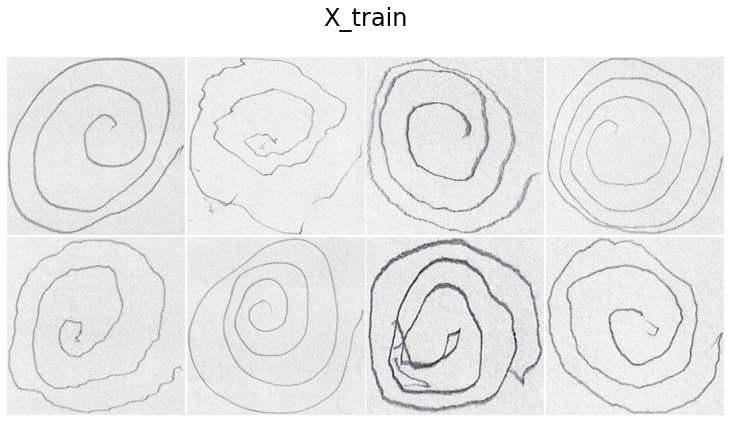

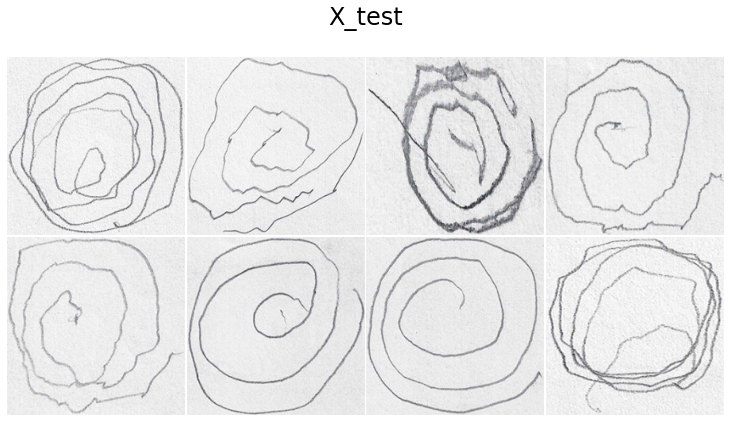

In [ ]:
plot_images(parkinson_x_train, 'X_train')
plot_images(parkinson_x_test, 'X_test')


### **Building and Visualizing model**

In [ ]:
vggModel = VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### **Image Augmentation**
To train on images at different positions, angles, flips, etc

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=4),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 4,
                    steps_per_epoch=len(X_train) / 4,
                    epochs=100)

Epoch 1/100
20/20 [==============================] - 1s 48ms/step - loss: 0.2452 - accuracy: 0.8750 - val_loss: 0.7552 - val_accuracy: 0.8182
Epoch 2/100
20/20 [==============================] - 1s 50ms/step - loss: 0.1470 - accuracy: 0.9250 - val_loss: 0.7896 - val_accuracy: 0.8182
Epoch 3/100
20/20 [==============================] - 1s 50ms/step - loss: 0.2903 - accuracy: 0.9125 - val_loss: 0.8526 - val_accuracy: 0.8182
Epoch 4/100
20/20 [==============================] - 1s 49ms/step - loss: 0.4328 - accuracy: 0.8375 - val_loss: 0.8078 - val_accuracy: 0.8182
Epoch 5/100
20/20 [==============================] - 1s 49ms/step - loss: 0.7300 - accuracy: 0.8125 - val_loss: 1.2684 - val_accuracy: 0.7273
Epoch 6/100
20/20 [==============================] - 1s 49ms/step - loss: 0.3277 - accuracy: 0.8875 - val_loss: 0.9501 - val_accuracy: 0.8182
Epoch 7/100
20/20 [==============================] - 1s 48ms/step - loss: 0.5681 - accuracy: 0.8250 - val_loss: 1.1417 - val_accuracy: 0.8182
Epoch 

In [ ]:
model.save('parkinson.h5')

In [ ]:
model.save_weights('parkinsonweights.hdf5')

In [ ]:
model = load_model('parkinson.h5')

### **Making Predicions**

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)

### Visulaizing First 10 predictions

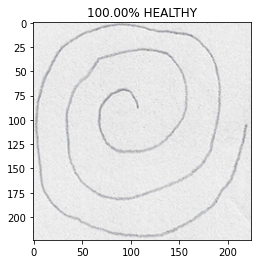

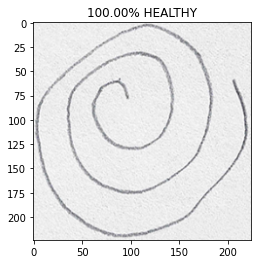

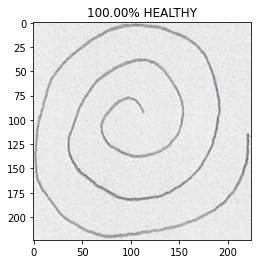

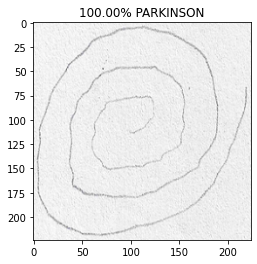

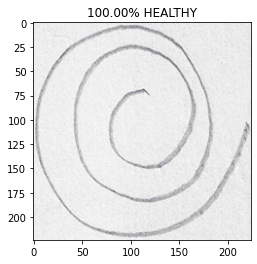

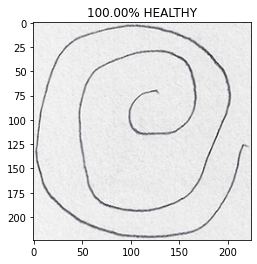

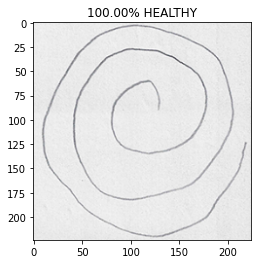

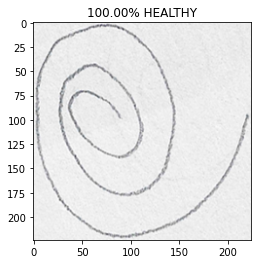

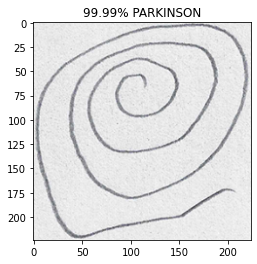

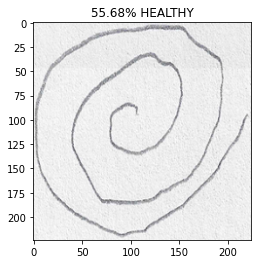

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% PARKINSON')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% HEALTHY')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

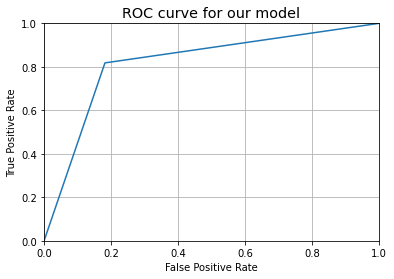

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


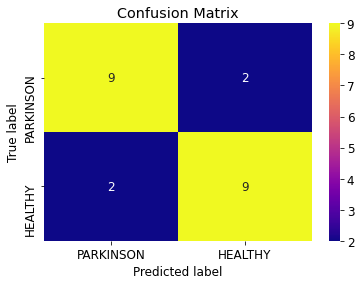

Confusion Matrix with Normalized Values


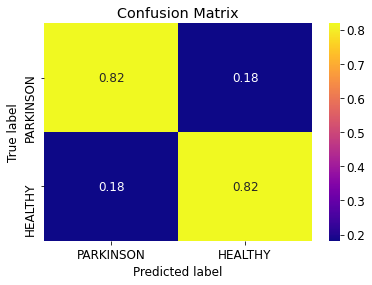

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['PARKINSON','HEALTHY']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        11
           1       0.82      0.82      0.82        11

    accuracy                           0.82        22
   macro avg       0.82      0.82      0.82        22
weighted avg       0.82      0.82      0.82        22



### **Accuracy and Loss Plots**

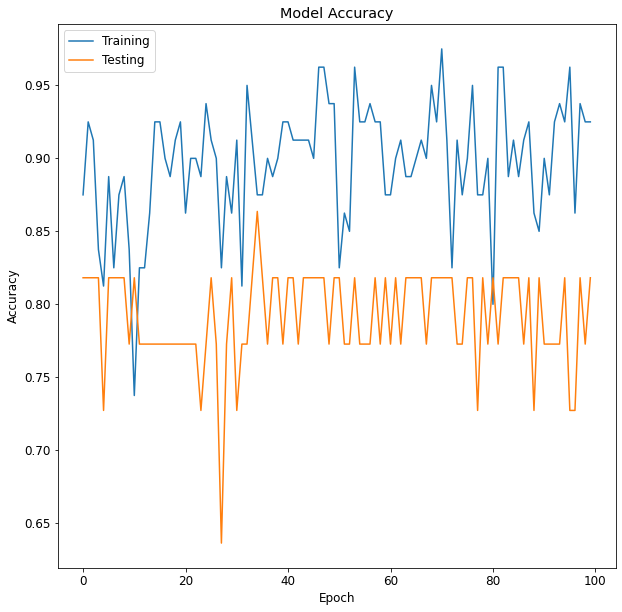

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()


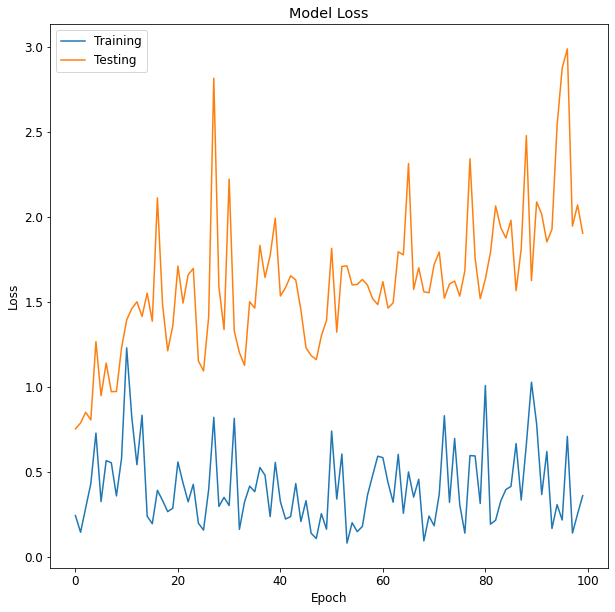

In [ ]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('parkinson_loss.png')
plt.show()